<a href="https://colab.research.google.com/github/AedinMcCann/Thesis/blob/main/FINAL_AMD_Rolling_Linear_comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [2]:
pip install yfinance

     |████████████████████████████████| 6.3MB 6.6MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23455 sha256=85cbafa1aad25b9da0fee3b9d016c64abebd5eba5f2ddc4c1c936dab747494f2
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [3]:
pip install yahoofinancials

  Created wheel for yahoofinancials: filename=yahoofinancials-1.6-cp37-none-any.whl size=15192 sha256=85f846f032243ebc7e587d713d037ae61e7da1845680cc37c60e94a701dac7ae
  Stored in directory: /root/.cache/pip/wheels/d9/7e/cf/4977a8572d5247242a4b13018d1d36923024ba84236e0d28bc
Successfully built yahoofinancials


In [4]:
pip install pyfinance

     |████████████████████████████████| 61kB 3.1MB/s 


In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from yahoofinancials import YahooFinancials
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
import pyfinance
from pyfinance import ols
import pandas_datareader as pdr
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data

In [6]:
# Get stock data
start='2020-01-01'
end='2021-01-02'
df = yf.download(tickers = "AMD",start=start,end=end,interval = "60m")
df.reset_index(drop=False, inplace=True)

nan_value = float("NaN")
df.replace("", nan_value, inplace=True)
df.tail()
df['Next_close'] = df['Close'].shift(-1)
df.tail()

[*********************100%***********************]  1 of 1 completed


,Datetime,Open,High,Low,Close,Adj Close,Volume,Next_close
1759,2020-12-31 11:30:00-05:00,91.879997,91.970001,90.919998,91.360001,91.360001,3298999,91.040001
1760,2020-12-31 12:30:00-05:00,91.375000,91.434998,90.940002,91.040001,91.040001,1922231,91.379997
1761,2020-12-31 13:30:00-05:00,91.040001,91.425003,90.930000,91.379997,91.379997,2127126,91.379997
1762,2020-12-31 14:30:00-05:00,91.385002,91.730003,91.353302,91.379997,91.379997,2276706,91.720001
1763,2020-12-31 15:30:00-05:00,91.379997,91.910004,91.209999,91.720001,91.720001,2568479,NaN


In [7]:
# Add in some technical indicators
# Simple moving average (SMA)
# 3 day period
Close = df[['Close']]
df['SMA'] = df.Close.rolling(3, min_periods=1).mean()

# Exponential moving average (EMA)
df['EMA'] = df.Close.ewm(alpha=0.1, adjust=False).mean()

In [8]:
# On Balance Volume
# Measures cumulative buying and selling pressure by adding the volume on "up" days and subtracting volume on "down" days. 
df['obv'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
df = df.set_index('Datetime')
df

,Open,High,Low,Close,Adj Close,Volume,Next_close,SMA,EMA,obv
Datetime,,,,,,,,,,
2020-01-02 09:30:00-05:00,46.860001,47.889999,46.630001,47.648102,47.648102,21996083,47.805000,47.648102,47.648102,0.0
2020-01-02 10:30:00-05:00,47.650002,47.990002,47.590000,47.805000,47.805000,9411388,47.880001,47.726551,47.663792,9411388.0
2020-01-02 11:30:00-05:00,47.807499,47.980000,47.580002,47.880001,47.880001,6181828,48.444302,47.777701,47.685413,15593216.0
2020-01-02 12:30:00-05:00,47.885300,48.480000,47.880001,48.444302,48.444302,9641779,48.759998,48.043101,47.761301,25234995.0
2020-01-02 13:30:00-05:00,48.450001,48.779999,48.299999,48.759998,48.759998,8224645,48.965000,48.361434,47.861171,33459640.0
...,...,...,...,...,...,...,...,...,...,...
2020-12-31 11:30:00-05:00,91.879997,91.970001,90.919998,91.360001,91.360001,3298999,91.040001,91.651667,91.693862,780024567.0
2020-12-31 12:30:00-05:00,91.375000,91.434998,90.940002,91.040001,91.040001,1922231,91.379997,91.423335,91.628476,778102336.0
2020-12-31 13:30:00-05:00,91.040001,91.425003,90.930000,91.379997,91.379997,2127126,91.379997,91.260000,91.603628,780229462.0


In [9]:
df = df[['Next_close', 'Close','Volume','Open','High','Low', "SMA", 'EMA', 'obv']]

In [10]:
dataset = df.values
scaler = MinMaxScaler()
# transform data
dataset = scaler.fit_transform(dataset)

X = dataset[:-1,1:]
y = dataset[:-1, 0]
x = pd.DataFrame(X)
y = pd.DataFrame(y)

In [11]:
rolling = ols.PandasRollingOLS(y=y, x=X, window=130)
y_pred = rolling.predicted
y_pred = pd.DataFrame(y_pred)
y_pred

predicted
end  subperiod           
129  0           0.173367
     1           0.176635
     2           0.178396
     3           0.186962
     4           0.191578
...                   ...
1762 1758        0.908943
     1759        0.902195
     1760        0.897120
     1761        0.900238
     1762        0.905013

[212420 rows x 1 columns]

In [12]:
y_pred = y_pred.reset_index()
counts= y_pred['subperiod'].value_counts()
y_pred = y_pred.groupby('subperiod').sum('predicted')
y_pred['predicted'] = y_pred['predicted']/counts
y_pred = y_pred.reset_index()
y_pred

,subperiod,end,predicted
0,0,129,0.173367
1,1,259,0.176508
2,2,390,0.178280
3,3,522,0.186641
4,4,655,0.191170
...,...,...,...
1758,1758,8800,0.908917
1759,1759,7042,0.902192
1760,1760,5283,0.897100
1761,1761,3523,0.900216


In [13]:
df_y = y.reset_index()
df_y = df_y.rename(columns={'index':'period', 0:'actual'})
df_y

,period,actual
0,0,0.175449
1,1,0.176695
2,2,0.186075
3,3,0.191323
4,4,0.194731
...,...,...
1758,1758,0.899435
1759,1759,0.894116
1760,1760,0.899767
1761,1761,0.899767


In [14]:
linear = df_y.join(y_pred, how='outer')
linear['difference'] = linear['actual'] - linear['predicted']
linear = linear.drop(['period','subperiod','end'], axis=1)
linear['sq_er'] = linear['difference']*linear['difference']
linear['AMD_RMSE_LIN'] = np.sqrt(linear['sq_er'])
linear

,actual,predicted,difference,sq_er,AMD_RMSE_LIN
0,0.175449,0.173367,0.002082,4.333874e-06,0.002082
1,0.176695,0.176508,0.000187,3.496729e-08,0.000187
2,0.186075,0.178280,0.007795,6.076894e-05,0.007795
3,0.191323,0.186641,0.004682,2.191857e-05,0.004682
4,0.194731,0.191170,0.003561,1.267759e-05,0.003561
...,...,...,...,...,...
1758,0.899435,0.908917,-0.009483,8.991901e-05,0.009483
1759,0.894116,0.902192,-0.008077,6.523228e-05,0.008077
1760,0.899767,0.897100,0.002667,7.111864e-06,0.002667
1761,0.899767,0.900216,-0.000449,2.017143e-07,0.000449


In [15]:
MSE = linear['sq_er'].sum()/len(linear)
import math 
RMSE = math.sqrt(MSE)
RMSE

0.012603403562250518

## With sentiment

In [16]:
df = df.reset_index()
df['date'] = df['Datetime'].dt.date  # for daily sentiment
df['datehour'] = df['Datetime'].dt.hour     #For hourly sentiment
df['hour_id'] = df['date'].map(str) + '.' + df['datehour'].map(str) 
df['hour_id']

0        2020-01-02.9
1       2020-01-02.10
2       2020-01-02.11
3       2020-01-02.12
4       2020-01-02.13
            ...      
1759    2020-12-31.11
1760    2020-12-31.12
1761    2020-12-31.13
1762    2020-12-31.14
1763    2020-12-31.15
Name: hour_id, Length: 1764, dtype: object

In [17]:
sent = pd.read_csv('AMD_sentiment_hr.csv')
df = pd.merge(df, sent, on = 'hour_id', how = 'left')
df = df.fillna(0)

In [18]:
df = df[['Next_close', 'Close','Volume','Open','High','Low', "SMA", 'EMA', 'obv', 'average']]

dataset = df.values

scaler = MinMaxScaler()
# transform data
dataset = scaler.fit_transform(dataset)

X = dataset[:-1,1:]
x = pd.DataFrame(X)
rolling = ols.PandasRollingOLS(y=y, x=X, window=130)
y_pred_sent = rolling.predicted
y_pred_sent = pd.DataFrame(y_pred_sent)
y_pred_sent = y_pred_sent.reset_index()
y_pred_sent = y_pred_sent.drop(['end'], axis=1)
y_pred_sent

,subperiod,predicted
0,0,0.173413
1,1,0.176716
2,2,0.177735
3,3,0.186780
4,4,0.191806
...,...,...
212415,1758,0.902578
212416,1759,0.900363
212417,1760,0.895904
212418,1761,0.900432


In [19]:
rolling.predicted

end   subperiod
129   0            0.173413
      1            0.176716
      2            0.177735
      3            0.186780
      4            0.191806
                     ...   
1762  1758         0.902578
      1759         0.900363
      1760         0.895904
      1761         0.900432
      1762         0.907321
Name: predicted, Length: 212420, dtype: float64

In [20]:
counts= y_pred_sent['subperiod'].value_counts()
y_pred_sent = y_pred_sent.groupby('subperiod').sum('predicted')
y_pred_sent['predicted_sent'] = y_pred_sent['predicted']/counts

In [21]:
linear_sent = df_y.join(y_pred_sent, how='outer')
linear_sent = linear_sent.rename(columns = {0:'actual'})
linear_sent

,period,actual,predicted,predicted_sent
0,0,0.175449,0.173413,0.173413
1,1,0.176695,0.353184,0.176592
2,2,0.186075,0.532835,0.177612
3,3,0.191323,0.745607,0.186402
4,4,0.194731,0.957105,0.191421
...,...,...,...,...
1758,1758,0.899435,4.512885,0.902577
1759,1759,0.894116,3.601477,0.900369
1760,1760,0.899767,2.687768,0.895923
1761,1761,0.899767,1.800878,0.900439


In [22]:
linear_sent['difference_sent'] = linear_sent['actual'] - linear_sent['predicted_sent']
linear_sent = linear_sent.drop(['predicted'], axis=1)
linear_sent['sq_er_sent'] = linear_sent['difference_sent']*linear_sent['difference_sent']
linear_sent['AMD_RMSE_LIN_SENTIMENT'] = np.sqrt(linear_sent['sq_er_sent'])
linear_sent

,period,actual,predicted_sent,difference_sent,sq_er_sent,AMD_RMSE_LIN_SENTIMENT
0,0,0.175449,0.173413,0.002036,4.144475e-06,0.002036
1,1,0.176695,0.176592,0.000104,1.072634e-08,0.000104
2,2,0.186075,0.177612,0.008464,7.163441e-05,0.008464
3,3,0.191323,0.186402,0.004921,2.421867e-05,0.004921
4,4,0.194731,0.191421,0.003310,1.095413e-05,0.003310
...,...,...,...,...,...,...
1758,1758,0.899435,0.902577,-0.003142,9.873304e-06,0.003142
1759,1759,0.894116,0.900369,-0.006253,3.910604e-05,0.006253
1760,1760,0.899767,0.895923,0.003845,1.478140e-05,0.003845
1761,1761,0.899767,0.900439,-0.000672,4.510326e-07,0.000672


In [23]:
MSE_sent = linear_sent['sq_er_sent'].sum()/len(linear_sent)
RMSE_sent = math.sqrt(MSE_sent)
RMSE_sent

0.012562638339050167

In [24]:
AMD_linear = pd.merge(linear, linear_sent, on = 'actual')
AMD_linear

,actual,predicted,difference,sq_er,AMD_RMSE_LIN,period,predicted_sent,difference_sent,sq_er_sent,AMD_RMSE_LIN_SENTIMENT
0,0.175449,0.173367,0.002082,4.333874e-06,0.002082,0,0.173413,0.002036,4.144475e-06,0.002036
1,0.176695,0.176508,0.000187,3.496729e-08,0.000187,1,0.176592,0.000104,1.072634e-08,0.000104
2,0.186075,0.178280,0.007795,6.076894e-05,0.007795,2,0.177612,0.008464,7.163441e-05,0.008464
3,0.191323,0.186641,0.004682,2.191857e-05,0.004682,3,0.186402,0.004921,2.421867e-05,0.004921
4,0.191323,0.186641,0.004682,2.191857e-05,0.004682,474,0.192607,-0.001284,1.648553e-06,0.001284
...,...,...,...,...,...,...,...,...,...,...
2072,0.894116,0.902192,-0.008077,6.523228e-05,0.008077,1759,0.900369,-0.006253,3.910604e-05,0.006253
2073,0.899767,0.897100,0.002667,7.111864e-06,0.002667,1760,0.895923,0.003845,1.478140e-05,0.003845
2074,0.899767,0.897100,0.002667,7.111864e-06,0.002667,1761,0.900439,-0.000672,4.510326e-07,0.000672
2075,0.899767,0.900216,-0.000449,2.017143e-07,0.000449,1760,0.895923,0.003845,1.478140e-05,0.003845


In [25]:
AMD_linear.describe()

,actual,predicted,difference,sq_er,AMD_RMSE_LIN,period,predicted_sent,difference_sent,sq_er_sent,AMD_RMSE_LIN_SENTIMENT
count,2077.000000,2077.000000,2077.000000,2.077000e+03,2077.000000,2077.000000,2077.000000,2077.000000,2.077000e+03,2077.000000
mean,0.461330,0.461287,0.000043,1.466730e-04,0.007851,866.861820,0.461290,0.000040,1.456771e-04,0.007821
std,0.279142,0.278924,0.012114,5.416730e-04,0.009223,505.543671,0.278921,0.012073,5.412983e-04,0.009195
min,0.000000,0.013635,-0.075720,6.847264e-11,0.000008,0.000000,0.013724,-0.075657,1.769216e-12,0.000001
25%,0.238200,0.235223,-0.005242,5.374053e-06,0.002318,445.000000,0.235428,-0.005221,5.249867e-06,0.002291
50%,0.302360,0.302115,0.000082,2.992048e-05,0.005470,843.000000,0.301507,-0.000016,2.846485e-05,0.005335
75%,0.746011,0.746620,0.005584,9.688921e-05,0.009843,1303.000000,0.746488,0.005537,9.515571e-05,0.009755
max,1.000000,0.995110,0.114869,1.319480e-02,0.114869,1762.000000,0.995019,0.114965,1.321702e-02,0.114965


Text(0.5, 0.98, 'Root Mean Squared Error Distribution With Sentiment')

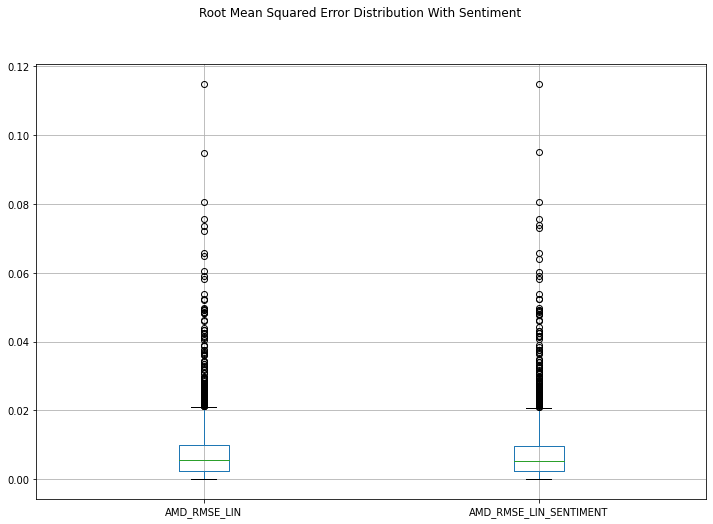

In [26]:
boxplot = AMD_linear.boxplot(column=['AMD_RMSE_LIN', 'AMD_RMSE_LIN_SENTIMENT'],figsize=(12,8))
[ax_tmp.set_xlabel('') for ax_tmp in np.asarray(boxplot).reshape(-1)]
fig = np.asarray(boxplot).reshape(-1)[0].get_figure()
fig.suptitle('Root Mean Squared Error Distribution With Sentiment')

In [27]:
AMD_linear_RMSE = AMD_linear[['AMD_RMSE_LIN', 'AMD_RMSE_LIN_SENTIMENT']]
AMD_linear_RMSE.describe()

,AMD_RMSE_LIN,AMD_RMSE_LIN_SENTIMENT
count,2077.000000,2077.000000
mean,0.007851,0.007821
std,0.009223,0.009195
min,0.000008,0.000001
25%,0.002318,0.002291
50%,0.005470,0.005335
75%,0.009843,0.009755
max,0.114869,0.114965


In [28]:
AMD_linear_RMSE.to_csv('AMD_Linear_Comms_Results.csv')